In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

from utils import * 

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
def BuildConvolutionBlock(inp, filters_count):
    conv = Conv2D(filters_count[0], (3, 3), padding='same')(inp)
    conv = Activation('relu')(conv)
    
    for filter_count in filters_count[1:]:
        conv = Conv2D(filters_count[0], (3, 3), padding='same')(conv)
        conv = Activation('relu')(conv)
    
    return conv

def BuildModel_HRNet_without_cross():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_fs_1 = BuildConvolutionBlock(inp, [32, 32])
    conv_fs_2 = BuildConvolutionBlock(conv_fs_1, [64, 64])
    conv_fs_3 = BuildConvolutionBlock(conv_fs_2, [64, 64])
    conv_fs_4 = BuildConvolutionBlock(conv_fs_3, [64, 64])

    conv_fs_1_pool = MaxPooling2D(2)(conv_fs_1)
    conv_hs_1 = BuildConvolutionBlock(conv_fs_1_pool, [32, 32])
    conv_hs_2 = BuildConvolutionBlock(conv_hs_1, [64, 64])
    conv_hs_3 = BuildConvolutionBlock(conv_hs_2, [64, 64])
    conv_hs_3_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_3)

    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2)
    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2_pool)
    conv_hs_1_pool = MaxPooling2D(2)(conv_hs_1)
    conv_qs_1 = BuildConvolutionBlock(Concatenate()([conv_fs_2_pool, conv_hs_1_pool]), [32, 32])
    conv_qs_2 = BuildConvolutionBlock(conv_qs_1, [64, 64])
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2_up)
    
    
    concat = Concatenate()([conv_fs_4, conv_hs_3_up, conv_qs_2_up])
    conv_out_1 = Conv2D(64, (3, 3), padding='same')(concat)
    conv_out_1 = Activation('relu')(conv_out_1)
    conv_out_2 = Conv2D(4, (3, 3), padding='same')(conv_out_1)
    result = Activation('sigmoid')(conv_out_2)

    return Model(inputs=inp, outputs=result)

def BuildModel_HRNet_with_cross():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    # 1
    conv_fs_1 = BuildConvolutionBlock(inp, [32, 32])

    # 1 -> 2
    conv_fs_1_pool = MaxPooling2D(2)(conv_fs_1)
    
    # 2    
    conv_hs_1 = BuildConvolutionBlock(conv_fs_1_pool, [32, 32])    
    conv_fs_2 = BuildConvolutionBlock(conv_fs_1, [64, 64])
    
    # 2 -> 3
    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2)
    conv_fs_2_pool_2 = MaxPooling2D(2)(conv_fs_2_pool)
    conv_hs_1_pool = MaxPooling2D(2)(conv_hs_1)
    
    conv_hs_1_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_1)
    
    # 3    
    conv_fs_3 = BuildConvolutionBlock(Concatenate()([conv_hs_1_up, conv_fs_2]), [64, 64])
    conv_hs_2 = BuildConvolutionBlock(Concatenate()([conv_hs_1, conv_fs_2_pool]), [64, 64])
    conv_qs_1 = BuildConvolutionBlock(Concatenate()([conv_fs_2_pool_2, conv_hs_1_pool]), [32, 32])
    
    # 3 -> 4
    conv_fs_3_pool = MaxPooling2D(2)(conv_fs_3)
    conv_fs_3_pool_2 = MaxPooling2D(2)(conv_fs_3_pool)
    conv_hs_2_pool = MaxPooling2D(2)(conv_hs_2)
    
    conv_hs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_2)
    conv_qs_1_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_1)
    conv_qs_1_up_2 = UpSampling2D(2, interpolation='bilinear')(conv_qs_1_up)
    
    # 4
    conv_fs_4 = BuildConvolutionBlock(Concatenate()([conv_fs_3, conv_hs_2_up, conv_qs_1_up_2]), [64, 64])
    conv_hs_3 = BuildConvolutionBlock(Concatenate()([conv_hs_2, conv_qs_1_up, conv_fs_3_pool]), [64, 64])
    conv_qs_2 = BuildConvolutionBlock(Concatenate()([conv_qs_1, conv_fs_3_pool_2, conv_hs_2_pool]), [64, 64])    
    
    # 4 -> out
    conv_hs_3_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_3)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2_up)
    
    # out
    concat = Concatenate()([conv_fs_4, conv_hs_3_up, conv_qs_2_up])
    conv_out_1 = Conv2D(64, (3, 3), padding='same')(concat)
    conv_out_1 = Activation('relu')(conv_out_1)
    conv_out_2 = Conv2D(4, (3, 3), padding='same')(conv_out_1)
    result = Activation('sigmoid')(conv_out_2)

    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('hrnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('hrnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


# model = BuildModel_HRNet_without_cross()
model = BuildModel_HRNet_with_cross()

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		20000
Number of files in Validation-set:	4000


In [4]:
batch_size = 16

steps_per_epoch = 100
epochs_count = 30
validation_steps = steps_per_epoch // 4

history = model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=epochs_count,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=validation_steps,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 56s 562ms/step - loss: 0.7579 - val_loss: 0.4615
Epoch 2/30
100/100 [==============================] - 52s 520ms/step - loss: 0.3916 - val_loss: 0.2993
Epoch 3/30
100/100 [==============================] - 52s 522ms/step - loss: 0.3314 - val_loss: 0.3381
Epoch 4/30
100/100 [==============================] - 52s 522ms/step - loss: 0.2927 - val_loss: 0.2777
Epoch 5/30
100/100 [==============================] - 52s 523ms/step - loss: 0.2657 - val_loss: 0.2578
Epoch 6/30
100/100 [==============================] - 52s 523ms/step - loss: 0.2541 - val_loss: 0.1782
Epoch 7/30
100/100 [==============================] - 52s 523ms/step - loss: 0.2337 - val_loss: 0.1690
Epoch 8/30
100/100 [==============================] - 52s 524ms/step - loss: 0.2288 - val_loss: 0.2120
Epoch 9/30
100/100 [==============================] - 52s 524ms/step - loss: 0.2157 - val_loss: 0.2842
Epoch 10/30
100/100 [====

dict_keys(['val_loss', 'loss'])


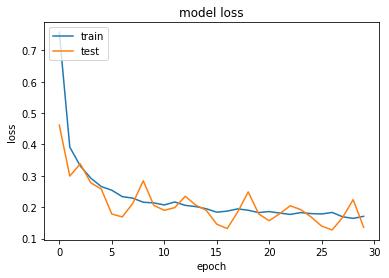

In [5]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
model = None
from keras.models import load_model
model1 = load_model('hrnet_best.h5')

In [7]:
testing_batch_size = 16
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, testing_batch_size):
    break

In [8]:
pred = model1.predict(x)

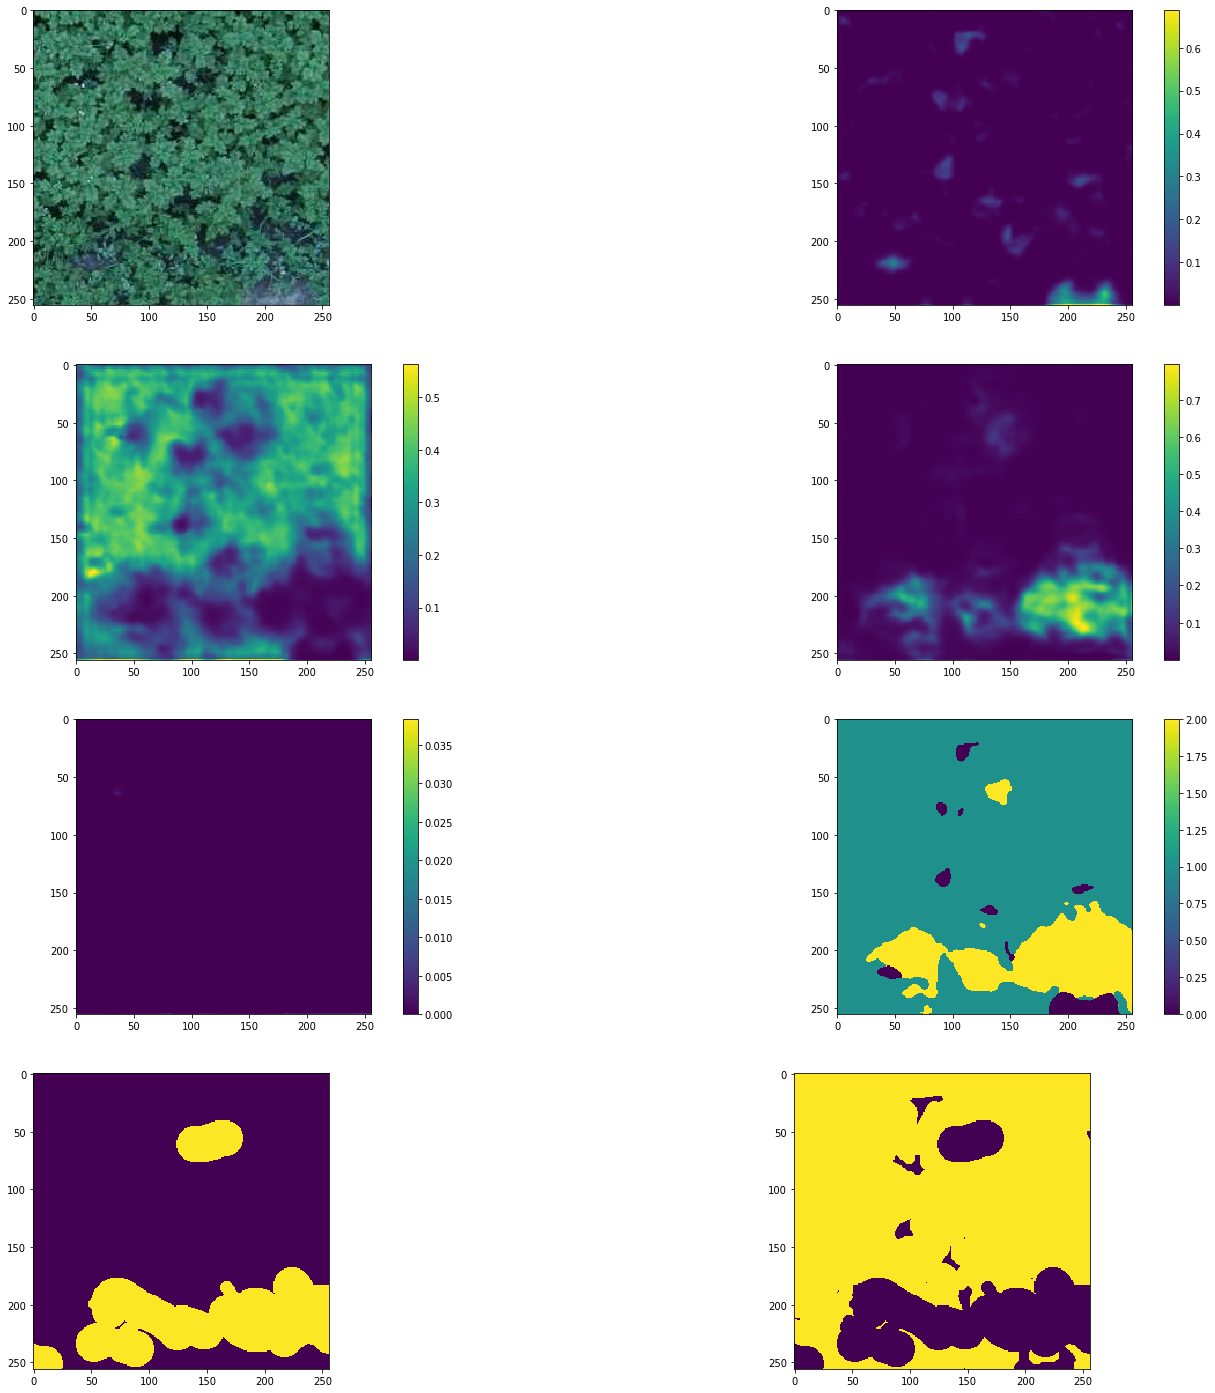

In [9]:
sample_index = 0
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
im_3_0 = axes[3][0].imshow(y[sample_index, ..., 2])
im_3_1 = axes[3][1].imshow(y[sample_index, ..., 1])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [10]:
CountErrors(y[sample_index], pred[sample_index]) 

(58533,
 {0: 1557, 1: 50275, 2: 13704, 3: 0},
 {0: [959, 0, 0, 0], 1: [0, 48491, 0, 0], 2: [0, 0, 9083, 0], 3: [0, 0, 0, 0]},
 {0: [0, 525, 73, 0],
  1: [613, 0, 1171, 0],
  2: [179, 4442, 0, 0],
  3: [0, 0, 0, 0]})

In [11]:
sample_index = 2

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [12]:
ok_cnt, required, valid, errors

(58676,
 {0: 3106, 1: 48819, 2: 13281, 3: 330},
 {0: [2015, 0, 0, 0],
  1: [0, 46419, 0, 0],
  2: [0, 0, 9977, 0],
  3: [0, 0, 0, 265]},
 {0: [0, 1052, 39, 0],
  1: [755, 0, 1628, 17],
  2: [142, 3162, 0, 0],
  3: [0, 65, 0, 0]})

In [13]:
sample_index = 5

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])   

In [14]:
ok_cnt, required, valid, errors

(63553,
 {0: 37125, 1: 28411, 2: 0, 3: 0},
 {0: [35946, 0, 0, 0], 1: [0, 27607, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 1179, 0, 0], 1: [804, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]})

### Image by image segmentation

In [15]:
img_name = './for_manual_tests/sample_38.png'
mask_name = './for_manual_tests/sample_38_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

In [16]:
pred = model1.predict(x)

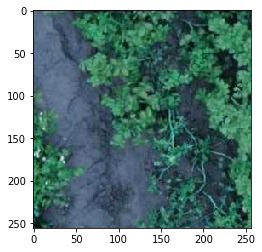

In [17]:
plt.imshow(x[0])

In [18]:
y.shape

(1, 256, 256, 4)

True

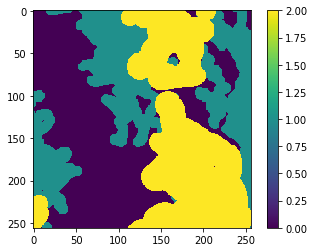

In [19]:
im_0_1 = plt.imshow(getClassesMap(y[0]))
plt.colorbar(im_0_1)

img = (getClassesMap(y[0]) * 255. / 3).astype(np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_mask.png", img)

In [20]:
np.min(pred[0, ..., 1]),np.max(pred[0, ..., 1])

(6.309152e-05, 0.52547693)

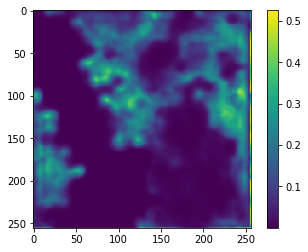

In [21]:
im_0_1 = plt.imshow(pred[0, ..., 1])
plt.colorbar(im_0_1)

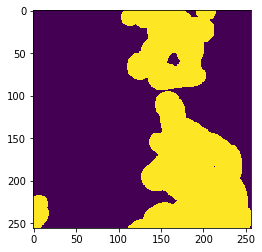

In [22]:
plt.imshow(y[0, ..., 2])

True

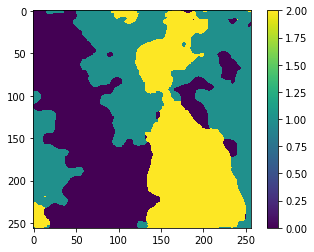

In [23]:
im_0_1 = plt.imshow(getClassesMap(pred[0]))
plt.colorbar(im_0_1)

img = (getClassesMap(pred[0]) * 255. / 3).astype(np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_hrnet.png", img)

In [24]:
sum(sum(getClassesMap(pred)))

29830

In [25]:
pred = model1.predict(x)

In [26]:
ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 

In [27]:
ok_cnt, required, valid, errors

(56388,
 {0: 24071, 1: 19429, 2: 22036, 3: 0},
 {0: [21385, 0, 0, 0],
  1: [0, 18002, 0, 0],
  2: [0, 0, 17001, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 2003, 683, 0],
  1: [885, 0, 542, 0],
  2: [765, 4270, 0, 0],
  3: [0, 0, 0, 0]})

### Estimate accuracy for validation set

In [28]:
all_ok_cnt = 0
all_required = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in tqdm(range(len(data.valid.image_paths))):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
#     pred[:,:,:,2] *= 2
    
    ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_required[j] = all_required[j] + required[j]
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_required[j] /= scale
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [29]:
all_ok_cnt, all_required, all_valid, all_errors

(93.28549346923828,
 {0: 13.678071975708008,
  1: 77.06314048767089,
  2: 8.743759536743164,
  3: 0.5150279998779297},
 {0: [11.89181137084961, 0.0, 0.0, 0.0],
  1: [0.0, 75.45011138916016, 0.0, 0.0],
  2: [0.0, 0.0, 5.473989868164063, 0.0],
  3: [0.0, 0.0, 0.0, 0.46958084106445314]},
 {0: [0.0, 1.5350666046142578, 0.23354568481445312, 0.0176483154296875],
  1: [0.7434932708740234, 0.0, 0.8224529266357422, 0.04708290100097656],
  2: [0.2914581298828125, 2.9782470703125, 0.0, 6.44683837890625e-05],
  3: [0.021891403198242187, 0.023519134521484374, 3.662109375e-05, 0.0]})

In [30]:
confusion_matrix = np.zeros([4,4])
for x in range(4):
    confusion_matrix[x,x] = all_valid[x][x]

for real_class in range(4):
    for predicted_class in range(4):
        if real_class == predicted_class:
            continue
        confusion_matrix[predicted_class,real_class] = all_errors[real_class][predicted_class]

precision = np.zeros([4])
for i in range(4):
    precision[i] = confusion_matrix[i,i] / sum(confusion_matrix[i,:])
    
recall = np.zeros([4])
for i in range(4):
    recall[i] = confusion_matrix[i,i] / sum(confusion_matrix[:,i])
        
def CalcF(precisionV, recallV):
    return 2 * precisionV * recallV / (precisionV + recallV)

F = [ CalcF(precisionV, recallV) for precisionV, recallV in zip(precision, recall) ]
F = np.array(F)

confusion_matrix, precision, recall, F
np.set_printoptions(precision=2)
np.set_printoptions(formatter={"float_kind": lambda x: "%0.2f" % x})

print("confusion_matrix = \n{}".format(confusion_matrix))
print("precision = {}".format(precision))
print("recall = {}".format(recall))
print("F = {}".format(F))

confusion_matrix = 
[[11.89 0.74 0.29 0.02]
 [1.54 75.45 2.98 0.02]
 [0.23 0.82 5.47 0.00]
 [0.02 0.05 0.00 0.47]]
precision = [0.92 0.94 0.84 0.88]
recall = [0.87 0.98 0.63 0.91]
F = [0.89 0.96 0.72 0.89]
